# Medical Image Classification Tutorial with the MedNIST Dataset

In this tutorial, we introduce an end-to-end training and evaluation example based on the MedNIST dataset.

We'll go through the following steps:
* Create a dataset for training and testing
* Use MONAI transforms to pre-process data
* Use the DenseNet from MONAI for classification
* Train the model with a PyTorch program
* Evaluate on test dataset

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/Project-MONAI/tutorials/blob/main/2d_classification/mednist_tutorial.ipynb)

## Setup environment

In [1]:
# !python -c "import monai" || pip install -q "monai-weekly[pillow, tqdm]"
# !python -c "import matplotlib" || pip install -q matplotlib
%matplotlib inline

## Setup imports

In [3]:
# Copyright 2020 MONAI Consortium
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#     http://www.apache.org/licenses/LICENSE-2.0
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

import os
import shutil
import tempfile
import matplotlib.pyplot as plt
import PIL
import torch
import numpy as np
from sklearn.metrics import classification_report

from monai.apps import download_and_extract
from monai.config import print_config
from monai.data import decollate_batch, DataLoader
from monai.metrics import ROCAUCMetric
from monai.networks.nets import DenseNet121
from monai.transforms import (
    Activations,
    EnsureChannelFirst,
    AsDiscrete,
    Compose,
    LoadImage,
    RandFlip,
    RandRotate,
    RandZoom,
    ScaleIntensity,
)
from monai.utils import set_determinism

from pathlib import Path
print_config()

MONAI version: 0.9.1
Numpy version: 1.23.1
Pytorch version: 1.10.0
MONAI flags: HAS_EXT = False, USE_COMPILED = False, USE_META_DICT = False
MONAI rev id: 356d2d2f41b473f588899d705bbc682308cee52c
MONAI __file__: /red/ufhpc/hityangsir/.conda/envs/monai-0.9.1/lib/python3.8/site-packages/monai/__init__.py

Optional dependencies:
Pytorch Ignite version: 0.4.9
Nibabel version: NOT INSTALLED or UNKNOWN VERSION.
scikit-image version: NOT INSTALLED or UNKNOWN VERSION.
Pillow version: 9.1.0
Tensorboard version: NOT INSTALLED or UNKNOWN VERSION.
gdown version: 4.5.1
TorchVision version: 0.10.0a0
tqdm version: 4.64.1
lmdb version: NOT INSTALLED or UNKNOWN VERSION.
psutil version: 5.9.2
pandas version: 1.4.0
einops version: NOT INSTALLED or UNKNOWN VERSION.
transformers version: NOT INSTALLED or UNKNOWN VERSION.
mlflow version: NOT INSTALLED or UNKNOWN VERSION.
pynrrd version: NOT INSTALLED or UNKNOWN VERSION.

For details about installing the optional dependencies, please visit:
    https://docs.

## Setup data directory

You can specify a directory with the `MONAI_DATA_DIRECTORY` environment variable.  
This allows you to save results and reuse downloads.  
If not specified a temporary directory will be used.

In [ ]:
directory = os.path.join(os.environ["HOME"], "ImageProcessingTutorial/MONAI_Tutorial") # os.environ.get("MONAI_DATA_DIRECTORY")
if directory is None:
    os.makedirs(directory)
root_dir = directory
print(root_dir)

## Download dataset

The MedNIST dataset was gathered from several sets from [TCIA](https://wiki.cancerimagingarchive.net/display/Public/Data+Usage+Policies+and+Restrictions),
[the RSNA Bone Age Challenge](http://rsnachallenges.cloudapp.net/competitions/4),
and [the NIH Chest X-ray dataset](https://cloud.google.com/healthcare/docs/resources/public-datasets/nih-chest).

The dataset is kindly made available by [Dr. Bradley J. Erickson M.D., Ph.D.](https://www.mayo.edu/research/labs/radiology-informatics/overview) (Department of Radiology, Mayo Clinic)
under the Creative Commons [CC BY-SA 4.0 license](https://creativecommons.org/licenses/by-sa/4.0/).

If you use the MedNIST dataset, please acknowledge the source.

In [5]:
resource = "https://github.com/Project-MONAI/MONAI-extra-test-data/releases/download/0.8.1/MedNIST.tar.gz"
md5 = "0bc7306e7427e00ad1c5526a6677552d"

compressed_file = os.path.join(root_dir, "MedNIST.tar.gz")
data_dir = os.path.join(root_dir, "MedNIST")
if not os.path.exists(data_dir):
    download_and_extract(resource, compressed_file, root_dir, md5)

## Set deterministic training for reproducibility

In [6]:
set_determinism(seed=0)

## Read image filenames from the dataset folders

First of all, check the dataset files and show some statistics.  
There are 6 folders in the dataset: Hand, AbdomenCT, CXR, ChestCT, BreastMRI, HeadCT,  
which should be used as the labels to train our classification model.

In [7]:
class_names = sorted(x for x in os.listdir(data_dir)
                     if os.path.isdir(os.path.join(data_dir, x)))
num_class = len(class_names)
image_files = [
    [
        os.path.join(data_dir, class_names[i], x)
        for x in os.listdir(os.path.join(data_dir, class_names[i]))
    ]
    for i in range(num_class)
]
num_each = [len(image_files[i]) for i in range(num_class)]
image_files_list = []
image_class = []
for i in range(num_class):
    image_files_list.extend(image_files[i])
    image_class.extend([i] * num_each[i])
num_total = len(image_class)
image_width, image_height = PIL.Image.open(image_files_list[0]).size

print(f"Total image count: {num_total}")
print(f"Image dimensions: {image_width} x {image_height}")
print(f"Label names: {class_names}")
print(f"Label counts: {num_each}")

Total image count: 58954
Image dimensions: 64 x 64
Label names: ['AbdomenCT', 'BreastMRI', 'CXR', 'ChestCT', 'Hand', 'HeadCT']
Label counts: [10000, 8954, 10000, 10000, 10000, 10000]


## Randomly pick images from the dataset to visualize and check

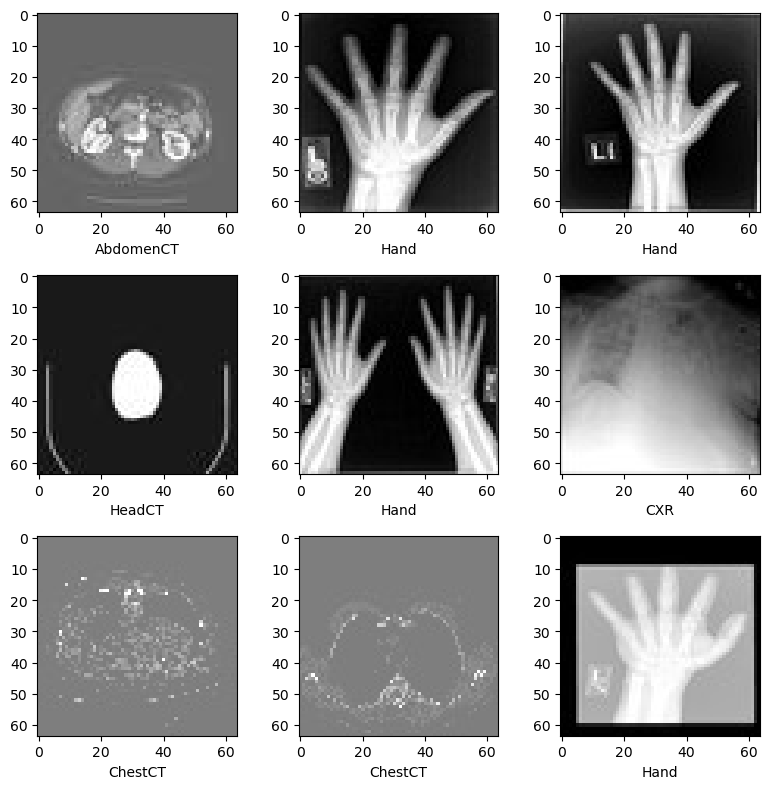

In [8]:
plt.subplots(3, 3, figsize=(8, 8))
for i, k in enumerate(np.random.randint(num_total, size=9)):
    im = PIL.Image.open(image_files_list[k])
    arr = np.array(im)
    plt.subplot(3, 3, i + 1)
    plt.xlabel(class_names[image_class[k]])
    plt.imshow(arr, cmap="gray", vmin=0, vmax=255)
plt.tight_layout()
plt.show()

## Prepare training, validation and test data lists

Randomly select 10% of the dataset as validation and 10% as test.

In [9]:
val_frac = 0.1
test_frac = 0.1
length = len(image_files_list)
indices = np.arange(length)
np.random.shuffle(indices)

test_split = int(test_frac * length)
val_split = int(val_frac * length) + test_split
test_indices = indices[:test_split]
val_indices = indices[test_split:val_split]
train_indices = indices[val_split:]

train_x = [image_files_list[i] for i in train_indices]
train_y = [image_class[i] for i in train_indices]
val_x = [image_files_list[i] for i in val_indices]
val_y = [image_class[i] for i in val_indices]
test_x = [image_files_list[i] for i in test_indices]
test_y = [image_class[i] for i in test_indices]

print(
    f"Training count: {len(train_x)}, Validation count: "
    f"{len(val_x)}, Test count: {len(test_x)}")

Training count: 47164, Validation count: 5895, Test count: 5895


## Define MONAI transforms, Dataset and Dataloader to pre-process data

In [10]:
train_transforms = Compose(
    [
        LoadImage(image_only=True),
        EnsureChannelFirst(),
        ScaleIntensity(),
        RandRotate(range_x=np.pi / 12, prob=0.5, keep_size=True),
        RandFlip(spatial_axis=0, prob=0.5),
        RandZoom(min_zoom=0.9, max_zoom=1.1, prob=0.5),
    ]
)

val_transforms = Compose(
    [LoadImage(image_only=True), EnsureChannelFirst(), ScaleIntensity()])

y_pred_trans = Compose([Activations(softmax=True)])
y_trans = Compose([AsDiscrete(to_onehot=num_class)])

In [11]:
class MedNISTDataset(torch.utils.data.Dataset):
    def __init__(self, image_files, labels, transforms):
        self.image_files = image_files
        self.labels = labels
        self.transforms = transforms

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, index):
        return self.transforms(self.image_files[index]), self.labels[index]


train_ds = MedNISTDataset(train_x, train_y, train_transforms)
train_loader = DataLoader(
    train_ds, batch_size=300, shuffle=True, num_workers=10)

val_ds = MedNISTDataset(val_x, val_y, val_transforms)
val_loader = DataLoader(
    val_ds, batch_size=300, num_workers=10)

test_ds = MedNISTDataset(test_x, test_y, val_transforms)
test_loader = DataLoader(
    test_ds, batch_size=300, num_workers=10)

## Define network and optimizer

1. Set learning rate for how much the model is updated per batch.
1. Set total epoch number, as we have shuffle and random transforms, so the training data of every epoch is different.  
And as this is just a get start tutorial, let's just train 4 epochs.  
If train 10 epochs, the model can achieve 100% accuracy on test dataset. 
1. Use DenseNet from MONAI and move to GPU devide, this DenseNet can support both 2D and 3D classification tasks.
1. Use Adam optimizer.

In [12]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = DenseNet121(spatial_dims=2, in_channels=1,
                    out_channels=num_class).to(device)
loss_function = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), 1e-5)
max_epochs = 4
val_interval = 1
auc_metric = ROCAUCMetric()

## Model training

Execute a typical PyTorch training that run epoch loop and step loop, and do validation after every epoch.  
Will save the model weights to file if got best validation accuracy.

In [13]:
best_metric = -1
best_metric_epoch = -1
epoch_loss_values = []
metric_values = []

for epoch in range(max_epochs):
    print("-" * 10)
    print(f"epoch {epoch + 1}/{max_epochs}")
    model.train()
    epoch_loss = 0
    step = 0
    for batch_data in train_loader:
        step += 1
        inputs, labels = batch_data[0].to(device), batch_data[1].to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = loss_function(outputs, labels)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
        print(
            f"{step}/{len(train_ds) // train_loader.batch_size}, "
            f"train_loss: {loss.item():.4f}")
        epoch_len = len(train_ds) // train_loader.batch_size
    epoch_loss /= step
    epoch_loss_values.append(epoch_loss)
    print(f"epoch {epoch + 1} average loss: {epoch_loss:.4f}")

    if (epoch + 1) % val_interval == 0:
        model.eval()
        with torch.no_grad():
            y_pred = torch.tensor([], dtype=torch.float32, device=device)
            y = torch.tensor([], dtype=torch.long, device=device)
            for val_data in val_loader:
                val_images, val_labels = (
                    val_data[0].to(device),
                    val_data[1].to(device),
                )
                y_pred = torch.cat([y_pred, model(val_images)], dim=0)
                y = torch.cat([y, val_labels], dim=0)
            y_onehot = [y_trans(i) for i in decollate_batch(y, detach=False)]
            y_pred_act = [y_pred_trans(i) for i in decollate_batch(y_pred)]
            auc_metric(y_pred_act, y_onehot)
            result = auc_metric.aggregate()
            auc_metric.reset()
            del y_pred_act, y_onehot
            metric_values.append(result)
            acc_value = torch.eq(y_pred.argmax(dim=1), y)
            acc_metric = acc_value.sum().item() / len(acc_value)
            if result > best_metric:
                best_metric = result
                best_metric_epoch = epoch + 1
                torch.save(model.state_dict(), os.path.join(
                    root_dir, "best_metric_model.pth"))
                print("saved new best metric model")
            print(
                f"current epoch: {epoch + 1} current AUC: {result:.4f}"
                f" current accuracy: {acc_metric:.4f}"
                f" best AUC: {best_metric:.4f}"
                f" at epoch: {best_metric_epoch}"
            )

print(
    f"train completed, best_metric: {best_metric:.4f} "
    f"at epoch: {best_metric_epoch}")

----------
epoch 1/4
1/157, train_loss: 1.7989
2/157, train_loss: 1.7612
3/157, train_loss: 1.7315
4/157, train_loss: 1.7188
5/157, train_loss: 1.6688
6/157, train_loss: 1.6470
7/157, train_loss: 1.6455
8/157, train_loss: 1.5991
9/157, train_loss: 1.5780
10/157, train_loss: 1.5703
11/157, train_loss: 1.5232
12/157, train_loss: 1.5322
13/157, train_loss: 1.4791
14/157, train_loss: 1.4522
15/157, train_loss: 1.4494
16/157, train_loss: 1.4270
17/157, train_loss: 1.4096
18/157, train_loss: 1.3601
19/157, train_loss: 1.3451
20/157, train_loss: 1.3280
21/157, train_loss: 1.3116
22/157, train_loss: 1.3129
23/157, train_loss: 1.2659
24/157, train_loss: 1.2709
25/157, train_loss: 1.2669
26/157, train_loss: 1.2500
27/157, train_loss: 1.2238
28/157, train_loss: 1.2123
29/157, train_loss: 1.1503
30/157, train_loss: 1.1591
31/157, train_loss: 1.1425
32/157, train_loss: 1.1489
33/157, train_loss: 1.1094
34/157, train_loss: 1.0751
35/157, train_loss: 1.0660
36/157, train_loss: 1.0884
37/157, train_lo

## Plot the loss and metric

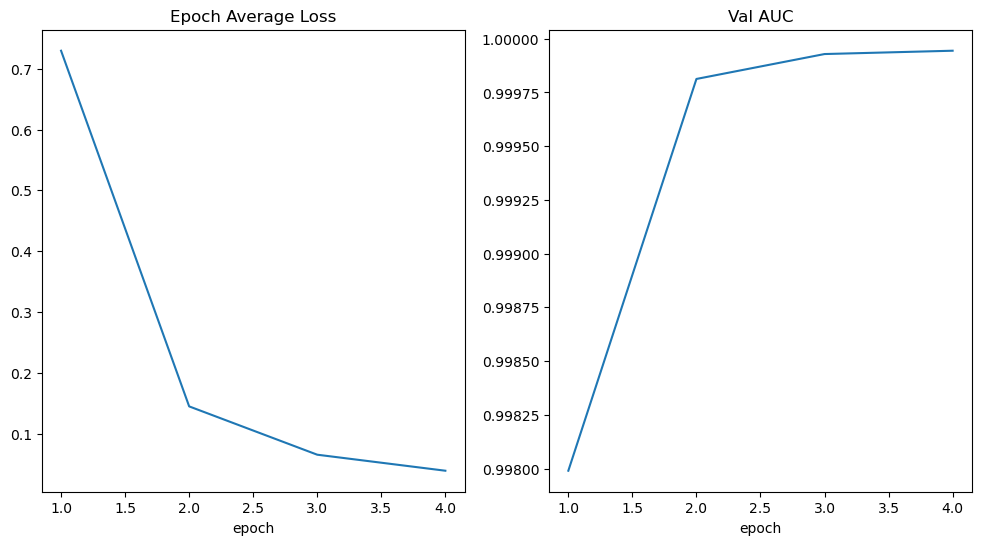

In [14]:
plt.figure("train", (12, 6))
plt.subplot(1, 2, 1)
plt.title("Epoch Average Loss")
x = [i + 1 for i in range(len(epoch_loss_values))]
y = epoch_loss_values
plt.xlabel("epoch")
plt.plot(x, y)
plt.subplot(1, 2, 2)
plt.title("Val AUC")
x = [val_interval * (i + 1) for i in range(len(metric_values))]
y = metric_values
plt.xlabel("epoch")
plt.plot(x, y)
plt.show()

## Evaluate the model on test dataset

After training and validation, we already got the best model on validation test.  
We need to evaluate the model on test dataset to check whether it's robust and not over-fitting.  
We'll use these predictions to generate a classification report.

In [15]:
model.load_state_dict(torch.load(
    os.path.join(root_dir, "best_metric_model.pth")))
model.eval()
y_true = []
y_pred = []
with torch.no_grad():
    for test_data in test_loader:
        test_images, test_labels = (
            test_data[0].to(device),
            test_data[1].to(device),
        )
        pred = model(test_images).argmax(dim=1)
        for i in range(len(pred)):
            y_true.append(test_labels[i].item())
            y_pred.append(pred[i].item())

In [16]:
print(classification_report(
    y_true, y_pred, target_names=class_names, digits=4))

              precision    recall  f1-score   support

   AbdomenCT     0.9910    0.9940    0.9925       995
   BreastMRI     0.9989    0.9955    0.9972       880
         CXR     0.9980    0.9980    0.9980       982
     ChestCT     0.9941    1.0000    0.9971      1014
        Hand     0.9981    0.9924    0.9952      1048
      HeadCT     0.9939    0.9939    0.9939       976

    accuracy                         0.9956      5895
   macro avg     0.9956    0.9956    0.9956      5895
weighted avg     0.9956    0.9956    0.9956      5895



## Cleanup data directory

Remove directory if a temporary was used.

In [ ]:
if directory is None:
    shutil.rmtree(root_dir)